In [1]:
import pandas as pd
from tqdm import tqdm
import os
import openai
import numpy as np
import pickle as pk
import seaborn as sns
import matplotlib.pyplot as plt
import json
# keys = json.load(open("keys.json"))
# os.environ["OPENAI_API_KEY"]=keys["OPENAI_API_KEY"]
# openai.api_key = os.environ.get("OPENAI_API_KEY")
# import together
# os.environ["TOGETHER_API_KEY"]=keys["TOGETHER_API_KEY"]
# together.api_key = os.environ.get("TOGETHER_API_KEY")
# pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('future.no_silent_downcasting', True)
from scipy.stats import chisquare

In [2]:
data2 = pd.read_csv("../csvs/hills.csv")
data3 = pd.read_csv("../csvs/noconstraints.csv")
data4 = pd.read_csv("../csvs/similar.csv")
data5 = pd.read_csv("../csvs/divergent.csv")

In [3]:
featuredict = pk.load(open(f"../files/features_gpt41.pk", "rb"))
feature_names = list(next(iter(featuredict.values())).keys())
response_to_featurevector = {k: [1 if values.get(f, "").lower()[:4] == "true" else 0 for f in feature_names] for k, values in featuredict.items()}

In [ ]:
data2

In [ ]:
featuredict = pk.load(open(f"../files/vf_features.pk", "rb"))
featuredf = pd.DataFrame.from_dict(featuredict, orient='index')
featuredf = featuredf.replace({'True': 1, 'True.': 1, 'False': 0, 'False.': 0})

In [ ]:
indices = featuredf.index[featuredf["feature_Is marsupial"] == 1].tolist()
print(indices)

In [ ]:
featuredf = featuredf[~featuredf.applymap(lambda x: isinstance(x, int)).all(axis=1)]

## Analyse features

In [4]:
def get_featuredf():
    featuredict = pk.load(open(f"../files/features_gpt41.pk", "rb"))
    featuredf = pd.DataFrame.from_dict(featuredict, orient='index')
    featuredf = featuredf.replace({True: 1, False: 0, 'True': 1, 'True.': 1, 'TRUE': 1, 'true': 1, 'False': 0, 'False.': 0, 'false': 0})
    # featuredf = featuredf[featuredf.applymap(lambda x: isinstance(x, int)).all(axis=1)]
    # featuredf = featuredf[featuredf.apply(lambda row: row.map(lambda x: isinstance(x, int)).all(), axis=1)]
    return featuredf, featuredf.columns.tolist()

vf_featuredf, vf_featurecols = get_featuredf()

In [ ]:
def correlation_matrix(df):
    correlation_matrix = df.corr()
    mask = np.triu(np.ones(correlation_matrix.shape), k=1)  # Upper triangle mask
    corr = correlation_matrix.where(mask == 0)
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr, annot=False, cmap='RdBu', fmt=".1f", mask=np.triu(np.ones_like(corr, dtype=bool)), vmin=-1, vmax=1)
    plt.show()
    return correlation_matrix

vf_featuredf_corr = correlation_matrix(vf_featuredf)

In [ ]:
# % of correlated features (greater than 0.5 corr)
print(np.mean(vf_featuredf_corr > 0.5))

# % of correlated features (less than -0.5 corr)
print(np.mean(vf_featuredf_corr < -0.5))

In [ ]:
def get_highly_correlated_columns(corr, threshold=0.75):
    # List to store highly correlated columns
    highly_correlated = {}
    
    # can change the logic to only keep correlated columns that as least correlated with others
    # if (np.sum(vf_featuredf_corr.loc["feature_Is mammal"].values) - 1)/(len(vf_featuredf_corr.loc["feature_Is mammal"].values) - 1)

    for i, col in enumerate(corr.columns):
        for prev_col in corr.columns[:i]:  # Check only previous columns
            if abs(corr.loc[col, prev_col]) >= threshold:  # Check correlation
                highly_correlated[col] = prev_col
                print(col, prev_col, corr.loc[col, prev_col])
                break
    
    return highly_correlated

high_corr_columns_vf = get_highly_correlated_columns(vf_featuredf_corr)

In [ ]:
remove_columns_vf = list(high_corr_columns_vf.keys())

## Add features to responses

In [5]:
def add_features_to_responsedf(df):
    featuredict = vf_featuredf.to_dict(orient='index')
    mapped_features = df['response'].map(featuredict)
    mapped_features = mapped_features.apply(lambda x: x if isinstance(x, dict) else {})
    fc = pd.DataFrame(mapped_features.tolist())
    df = pd.concat([df, fc], axis=1)
    df = df.replace({'True': 1, 'True.': 1, 'False': 0, 'False.': 0})
    dropped_rows = df[df[vf_featurecols].isna().any(axis=1)]
    df = df.dropna(subset=vf_featurecols)
    for col in vf_featurecols:
        df[col] = df[col].astype(int)
    return df, dropped_rows

data2, dropped_rows2 = add_features_to_responsedf(data2)
# data3, dropped_rows3 = add_features_to_responsedf(data3)
# data4, dropped_rows4 = add_features_to_responsedf(data4)
# data5, dropped_rows5 = add_features_to_responsedf(data5)

In [6]:
data2

,pid,response,RT,fpatchnum,fpatchitem,fitemsfromend,flastitem,meanirt,catitem,feature_Is mammal,feature_Is bird,feature_Is insect,feature_Is reptile,feature_Is amphibian,feature_Is fish,feature_Is rodent,feature_Is primate,feature_Is jungle animal,feature_Is non-jungle animal,feature_Is feline,feature_Is canine,feature_Is subspecies of an animal,feature_Is carnivore,feature_Is herbivore,feature_Is omnivore,feature_Is larger in size compared to other animals,feature_Is smaller in size compared to other animals,feature_Is average size compared to other animals,feature_Is warm-blooded,feature_Is cold-blooded,feature_Is a predator,feature_Is prey for larger animals,feature_Is a parasite,feature_Is a host for parasites,feature_Is nocturnal,feature_Is diurnal,feature_Has fur,feature_Has feathers,feature_Has scales,feature_Has exoskeleton,feature_Has beak,feature_Has claws,feature_Has whiskers,feature_Has horns,feature_Has antlers,feature_Has tusks,feature_Has wings,feature_Has tail,feature_Has less than four limbs,feature_Has exactly four limbs,feature_Has more than four limbs,feature_Has stripes,feature_Has spots,feature_Has mane,feature_Has crest,feature_Has gills,feature_Has flippers,feature_Has compound eyes,feature_Has segmented body,feature_Has a long neck,feature_Can fly,feature_Can swim,feature_Can climb,feature_Can dig,feature_Can jump,feature_Can camouflage,feature_Can hibernate,feature_Can be trained or tamed by humans,feature_Is found in zoos,feature_Lives in water,feature_Lives in trees,feature_Lives underground,feature_Lives on land,feature_Is native to Africa,feature_Is native to Asia,feature_Is native to North America,feature_Is native to South America,feature_Is native to Australia,feature_Is native to Europe,feature_Lives in Arctic/far North,feature_Is found in deserts,feature_Is found in forests,feature_Is found in oceans,feature_Is found in grasslands,feature_Is found in mountains,feature_Lives in burrows,feature_Lays eggs,feature_Gives birth,feature_Is venomous,feature_Is domesticated,feature_Lives in groups,feature_Is solitary,feature_Builds nests,feature_Is migratory,feature_Has social hierarchy,feature_Uses tools,feature_Shows intelligence,feature_Communicates vocally,feature_Can change color,feature_Is capable of mimicry,feature_Has echolocation,feature_Is known for speed,feature_Is known for strength,feature_Is kept as a pet,feature_Is used in farming,feature_Is hunted by humans,feature_Is used for food by humans,feature_Is used for transportation,feature_Is used in scientific research,feature_Has a long lifespan,feature_Has regenerative ability,feature_Is vertebrate,feature_Is invertebrate,feature_Is marsupial,feature_Is placental,feature_Is monotreme,feature_Is flightless,feature_Has webbed feet,feature_Is known for intelligence,feature_Is a scavenger,feature_Is territorial,feature_Is endangered,feature_Is bioluminescent,feature_Is capable of parental care,feature_Is a pollinator,feature_Can tolerate extreme temperatures,feature_Exhibits seasonal color changes,feature_Is active during dawn or dusk (crepuscular),feature_Produces pheromones for communication,feature_Lives symbiotically with other species,feature_Is bi-parental (both parents care for offspring),feature_Displays mating rituals,feature_Has specialized courtship behavior,feature_Exhibits territorial marking,feature_Is associated with mythology or folklore,feature_Exhibits altruistic behavior,feature_Is a keystone species in its ecosystem,feature_Can regenerate body parts,feature_Is raised in captivity or farms,"feature_Has unique reproductive strategies (e.g., asexual reproduction)",feature_Hibernates during winter,feature_Has a role in biological pest control,feature_Has distinct seasonal breeding cycles,"feature_Forms a symbiotic relationship with plants (e.g., pollination)",feature_Uses specific vocalizations to communicate,feature_Is a flagship species (conservation symbol),feature_Displays warning coloration
0,51,cat,8,1,1,2,0,5.200000,1,1

In [8]:
feature_cols = [col for col in data2.columns if col.startswith('feature_')]

for col in feature_cols:
    new_col = f"consecutive_{col}_bin"
    data2[new_col] = (
        data2.groupby('pid')[col]
        .transform(lambda x: (x != x.shift()).astype(int))
    )
    data2.loc[data2.groupby('pid').head(1).index, new_col] = np.nan

/tmp/ipykernel_315778/167400428.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data2[new_col] = (
/tmp/ipykernel_315778/167400428.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data2[new_col] = (
/tmp/ipykernel_315778/167400428.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data2[new_c

In [10]:
diff_df = pd.DataFrame()

for col in feature_cols:
    bin_col = f"consecutive_{col}_bin"
    temp = data2.dropna(subset=[bin_col])
    
    # Compute RT difference for each pid
    rt_diff = temp.groupby('pid').apply(
        lambda g: g.loc[g[bin_col]==0, 'RT'].mean() - g.loc[g[bin_col]==1, 'RT'].mean()
    )
    
    diff_df[col] = rt_diff

# Optional: reset index if you want 'pid' as a column
diff_df = diff_df.reset_index()

/tmp/ipykernel_315778/4063288324.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rt_diff = temp.groupby('pid').apply(
/tmp/ipykernel_315778/4063288324.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rt_diff = temp.groupby('pid').apply(
/tmp/ipykernel_315778/4063288324.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future versi

(array([ 1.,  0.,  3.,  5.,  9., 41., 45., 29.,  4.,  2.]),
 array([-12.82857143, -11.01      ,  -9.19142857,  -7.37285714,
         -5.55428571,  -3.73571429,  -1.91714286,  -0.09857143,
          1.72      ,   3.53857143,   5.35714286]),
 <BarContainer object of 10 artists>)

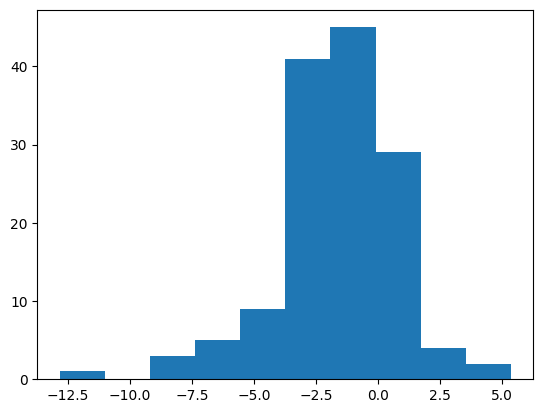

In [ ]:
plt.hist(diff_df["feature_Is mammal"]);

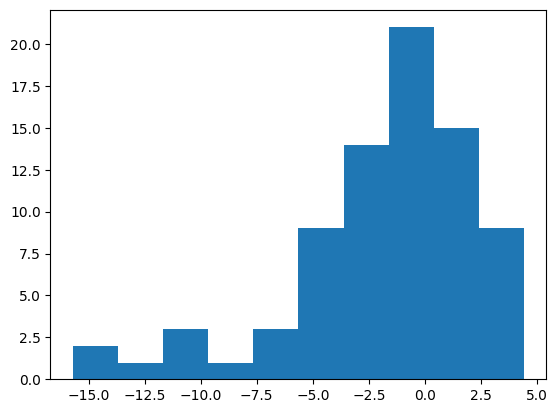

In [15]:
plt.hist(diff_df["feature_Is marsupial"]);

In [ ]:
feature_means = data2[[col for col in data2.columns if col.startswith("feature_")]].mean()

In [ ]:
feature_means.tolist()

In [ ]:
remove_columns_vf.extend([col for col in vf_featurecols if data2[col].mean() > 0.95 or data2[col].mean() < 0.05 and col != 'feature_Is insect'])

In [ ]:
remove_columns_vf

In [ ]:
vf_featuredf = vf_featuredf.drop(columns = remove_columns_vf)

In [ ]:
vf_featuredf

In [ ]:
featuredict = vf_featuredf.to_dict(orient='index')

In [ ]:
pk.dump(featuredict, open(f"../files/vf_features_updated.pk", "wb"))

In [ ]:
def plot_means(df, featuredf, featurecols):
    fig, ax = plt.subplots(1, 2, figsize=(6,2))
    ax[0].hist(featuredf.mean(axis=0).values);
    ax[0].set_xlabel("P(feature) = 1")
    ax[0].set_ylabel("Number of features")
    ax[1].hist(df[featurecols].mean(axis=0).values);
    ax[1].set_xlabel("P(feature) = 1 in responses")

plot_means(data_vf, vf_featuredf, vf_featurecols)

In [ ]:
def find_consecutive_ones(df, feature_col):
    # result = {}
    counts = {}
    for subject in df["pid"].unique():
        subject_data = df[df["pid"] == subject][feature_col].values
        # counts = {}
        current_count = 0
        for value in subject_data:
            if value == 1:
                current_count += 1
            elif current_count > 0:
                counts[current_count] = counts.get(current_count, 0) + 1
                current_count = 0
        # Add the last streak if it ends with a 1
        if current_count > 0:
            counts[current_count] = counts.get(current_count, 0) + 1 
        # result[subject] = counts
    # return result
    return counts

def make_persistance_plots(df, featuredf, featurecols):
    for col in featurecols:
        plt.figure(figsize = (2,2))
        p = df[featurecols].mean(axis=0).loc[col]   # response df
        p_ = featuredf.mean(axis=0).loc[col]        # feature df
        
        print(col, p, p_)

        fco = dict(sorted(find_consecutive_ones(df, col).items()))
        plt.plot(list(fco.keys()), np.array(list(fco.values())) / (np.sum(list(fco.values()))), label = "Data")
        
        x = np.arange(1, list(fco.keys())[-1] + 1)
        geometric_pdf = (p ** x) * (1 - p) 
        plt.plot(x, geometric_pdf, label = "Random")
        
        plt.legend()
        plt.show()

def make_persistance_plots_conditional(df, featuredf, featurecols):
    cols_to_remove = []
    for col in featurecols:
        plt.figure(figsize = (2,2))
        p = df[featurecols].mean(axis=0).loc[col]   # response df
        p_ = featuredf.mean(axis=0).loc[col]        # feature df
        
        print(col, p, p_)

        fco = dict(sorted(find_consecutive_ones(df, col).items()))
        print(fco)
        x = np.array(list(fco.keys()))
        
        data_values = np.array(list(fco.values()))
        observed = data_values / np.sum(data_values)
        plt.plot(x, observed, label = "Data")
        
        geometric_pdf = (p ** (x - 1)) * (1 - p) 
        plt.plot(x, geometric_pdf, label = "Random")

        # expected = geometric_pdf * np.sum(data_values)
        # expected *= np.sum(data_values) / np.sum(expected)

        chi2_stat, p_value = chisquare(data_values, f_exp=geometric_pdf / np.sum(geometric_pdf) * np.sum(data_values))
        print(f"Chi-Square Statistic: {chi2_stat}, p-value: {p_value}")
        if p_value > 0.01:
            cols_to_remove.append(col)
        
        plt.legend()
        plt.show()
    return cols_to_remove

def make_persistance_plots_hazard(df, featuredf, featurecols):
    for col in featurecols:
        plt.figure(figsize = (2,2))
        p = df[featurecols].mean(axis=0).loc[col]   # response df
        p_ = featuredf.mean(axis=0).loc[col]        # feature df
        
        print(col, p, p_)

        fco = dict(sorted(find_consecutive_ones(df, col).items()))

        remaining_population = sum(fco.values())
        hazard_function = []

        for i, freq_i in fco.items():
            hazard_function.append(freq_i / remaining_population)  # Hazard probability for i
            remaining_population -= freq_i

        plt.plot(list(fco.keys()), hazard_function, label = "Data")
        
        x = np.arange(1, list(fco.keys())[-1] + 1)
        geometric_pdf = [(1 - p)] * len(x)
        plt.plot(x, geometric_pdf, label = "Random")
        
        plt.legend()
        plt.show()

In [ ]:
# remove_columns_vf.extend(make_persistance_plots_conditional(data_vf, vf_featuredf, vf_featurecols))

In [ ]:
# make_persistance_plots_hazard(data_vf, vf_featuredf, vf_featurecols)

In [ ]:
# remove_columns_autbrick.extend(make_persistance_plots_conditional(data_autbrick, autbrick_featuredf, autbrick_featurecols))

In [ ]:
# make_persistance_plots_hazard(data_autbrick, autbrick_featuredf, autbrick_featurecols)

In [ ]:
# remove_columns_autpaperclip.extend(make_persistance_plots_conditional(data_autpaperclip, autpaperclip_featuredf, autpaperclip_featurecols))

In [ ]:
# make_persistance_plots_hazard(data_autpaperclip, autpaperclip_featuredf, autpaperclip_featurecols)

# Remove features

In [ ]:
vf_featuredf = vf_featuredf.drop(columns = remove_columns_vf)
data_vf = data_vf.drop(columns = remove_columns_vf)
vf_featurecols = [item for item in vf_featurecols if item not in remove_columns_vf]

# autbrick_featuredf = autbrick_featuredf.drop(columns = remove_columns_autbrick)
# # add data line
# autbrick_featurecols = [item for item in autbrick_featurecols if item not in remove_columns_autbrick]

# autpaperclip_featuredf = autpaperclip_featuredf.drop(columns = remove_columns_autpaperclip)
# # add data line
# autpaperclip_featurecols = [item for item in autpaperclip_featurecols if item not in remove_columns_autpaperclip]

Text(0.5, 1.0, 'Top 5 and Bottom 5 Most Active Features -- UNIFORM')

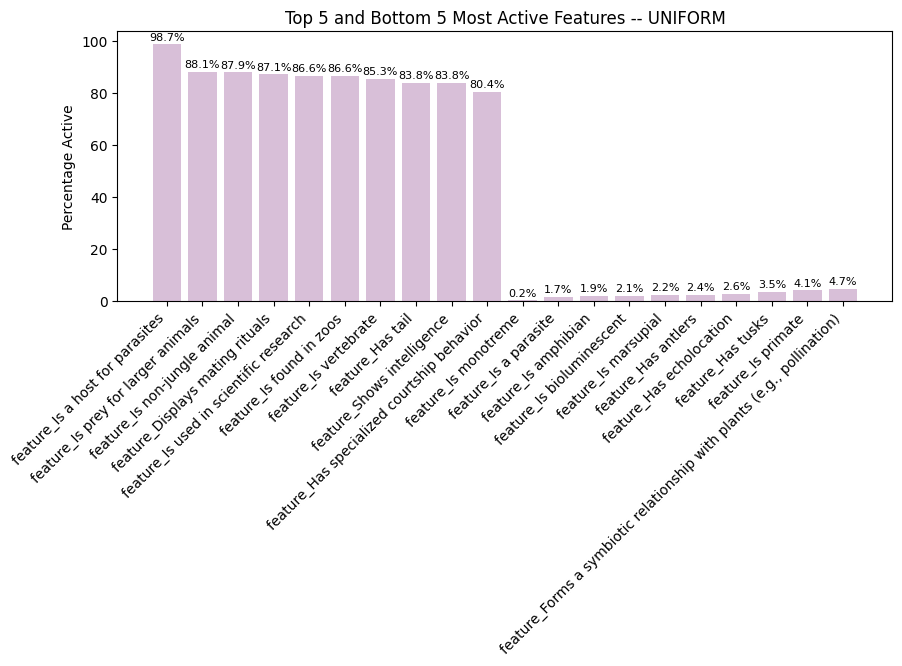

In [17]:
percent_active = vf_featuredf.mean() * 100
top5 = percent_active.sort_values(ascending=False).head(10)
bottom5 = percent_active.sort_values().head(10)

# Concatenate for plotting
combined = pd.concat([top5, bottom5])

# Plot
plt.figure(figsize=(10, 3.5))
bars = plt.bar(combined.index, combined.values, color="#D8BFD8")

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{height:.1f}%", 
             ha='center', va='bottom', fontsize=8)

plt.xticks(rotation=45, ha='right')
plt.ylabel("Percentage Active")
plt.title("Top 5 and Bottom 5 Most Active Features -- UNIFORM")

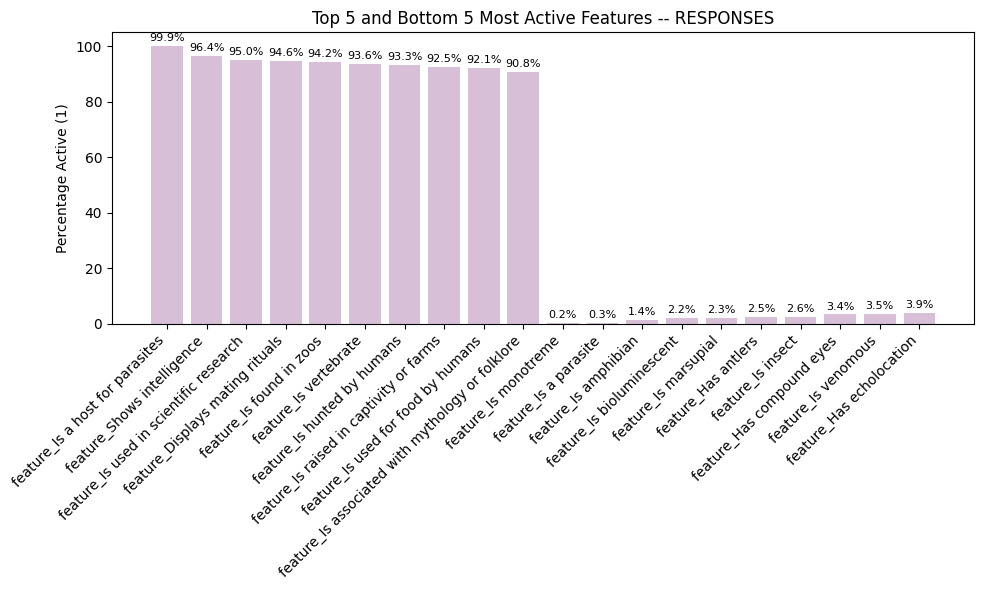

In [18]:
percent_active2 = data2[vf_featurecols].mean() * 100
top5 = percent_active2.sort_values(ascending=False).head(10)
bottom5 = percent_active2.sort_values().head(10)

# Concatenate for plotting
combined = pd.concat([top5, bottom5])

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(combined.index, combined.values, color="#D8BFD8")

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{height:.1f}%", 
             ha='center', va='bottom', fontsize=8)

plt.xticks(rotation=45, ha='right')
plt.ylabel("Percentage Active (1)")
plt.title("Top 5 and Bottom 5 Most Active Features -- RESPONSES")
plt.tight_layout()
plt.show()

In [ ]:
percent_diff = percent_active2.subtract(percent_active)

percent_diff = percent_active2.subtract(percent_active)
top5 = percent_diff.sort_values(ascending=False).head(10)
bottom5 = percent_diff.sort_values().head(10)

# Concatenate for plotting
combined = pd.concat([top5, bottom5])

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(combined.index, combined.values, color="#D8BFD8")

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{height:.1f}%", 
             ha='center', va='bottom', fontsize=8)

plt.xticks(rotation=45, ha='right')
plt.ylabel("Percentage Active (1)")
plt.title("Top 5 and Bottom 5 Most Active Features")
plt.tight_layout()
plt.show()

In [ ]:
print(len(vf_featurecols)) #, len(autbrick_featurecols), len(autpaperclip_featurecols))

In [ ]:
final_features = vf_featurecols[:3] + ["feature_Is reptile", "feature_Is amphibian"] + vf_featurecols[3:]
pk.dump(final_features, open("../files/vf_final_features.pk", "wb"))

In [16]:
def get_num_features_same(df, featurecols):
    df['num_features_same'] = None
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols = featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    num_features_same = [np.nan]  # Initialize with nan for the first row
    
    for i in range(1, len(group)):
        row1 = group.loc[i - 1, featurecols]
        row2 = group.loc[i, featurecols]
        
        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same.append(np.nan)
        else:
            consecutive_1s = ((row1 == 1) & (row2 == 1)) | ((row1 == 0) & (row2 == 0))
            num_features_same.append(consecutive_1s.sum())
    
    group['num_features_same'] = num_features_same
    return group

# data_vf = get_num_features_same(data_vf, vf_featurecols)
data2 = get_num_features_same(data2, vf_featurecols)
# data3 = get_num_features_same(data3, vf_featurecols)
# data4 = get_num_features_same(data4, vf_featurecols)
# data5 = get_num_features_same(data5, vf_featurecols)
# data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
# data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

/tmp/ipykernel_315778/2540658455.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['num_features_same'] = None
/tmp/ipykernel_315778/2540658455.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols = featurecols)


In [ ]:
data2

In [ ]:
Q1 = data2["RT"].quantile(0.25)
Q3 = data2["RT"].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for non-outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame
data2_no_outliers = data2[(data2["RT"] >= lower_bound) & (data2["RT"] <= upper_bound)]

In [ ]:
# Compute log RT
data2_no_outliers["RT"] = data2_no_outliers["RT"] + 0.001
data2_no_outliers["logRT"] = np.log(data2_no_outliers["RT"])

# Bin `num_features_same` into strips of width 5
bin_edges = np.arange(data2_no_outliers["num_features_same"].min() + 10, 
                      data2_no_outliers["num_features_same"].max(), 
                      10)
data2_no_outliers["bin"] = pd.cut(data2_no_outliers["num_features_same"], bins=bin_edges)

# Compute mean logRT per bin
mean_logRT = data2_no_outliers.groupby("bin")["logRT"].mean()
bin_centers = [interval.mid for interval in mean_logRT.index]

# Overlay mean logRT per strip
plt.plot(bin_centers, mean_logRT.values, color='red', marker='o')

# Labels and formatting
plt.xlabel("num_features_same")
plt.ylabel("Mean log(RT)")
plt.title("Scatter of log(RT) vs. num_features_same with binned mean");

bin_labels = [f"{int(interval.left)}-{int(interval.right)}" for interval in mean_logRT.index]
plt.xticks(ticks=bin_centers, labels=bin_labels, rotation=45)

In [ ]:
data2_no_outliers["RT"] = data2_no_outliers["RT"] + 0.001
data2_no_outliers["logRT"] = np.log(data2_no_outliers["RT"])

# Step 2: Quantile binning into 10 equal-sized bins
data2_no_outliers["bin"] = pd.qcut(data2_no_outliers["num_features_same"], q=15)

# Step 3: Group by bin and compute mean logRT
mean_logRT = data2_no_outliers.groupby("bin")["logRT"].mean()

# Step 4: Create integer x positions and corresponding labels
x_positions = np.arange(len(mean_logRT))
bin_labels = [f"{int(interval.left)}–{int(interval.right)}" for interval in mean_logRT.index]

# Step 5: Plot
plt.plot(x_positions, mean_logRT.values, color='red', marker='o')

# Step 6: Format x-axis to show bin ranges at equal spacing
plt.xticks(ticks=x_positions, labels=bin_labels, rotation=45)
plt.xlabel("num_features_same (quantile bins)")
plt.ylabel("Mean log(RT)")

In [ ]:
def get_dot_product(df, featurecols):
    df['dot_product'] = None
    df = df.groupby('pid', group_keys=False).apply(calculate_dot_product, featurecols = featurecols)
    return df

def calculate_dot_product(group, featurecols):
    group = group.reset_index(drop=True)
    dot_product = [np.nan, np.nan]  # Initialize with nan for the first row
    
    for i in range(2, len(group)):
        row1 = group.loc[i - 2, featurecols]
        row2 = group.loc[i - 1, featurecols]
        row3 = group.loc[i, featurecols]
        
        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            dot_product.append(np.nan)
        else:
            vec1 = (row1 == row2).astype(int)
            vec2 = (row2 == row3).astype(int)
            dot_product.append(np.dot(vec1, vec2))
    
    group['dot_product'] = dot_product  
    return group

# data_vf = get_dot_product(data_vf, vf_featurecols)
data2 = get_dot_product(data2, vf_featurecols)
# data3 = get_dot_product(data3, vf_featurecols)
# data4 = get_dot_product(data4, vf_featurecols)
# data5 = get_dot_product(data5, vf_featurecols)

In [ ]:
def calculate_dot_product(group, featurecols):
    group = group.reset_index(drop=True)
    n = len(group)
    
    if n < 3:
        group['dot_product'] = [np.nan] * n
        return group
    
    dot_product = [np.nan, np.nan]  # For first two rows

    for i in range(2, n):
        row1 = group.loc[i - 2, featurecols]
        row2 = group.loc[i - 1, featurecols]
        row3 = group.loc[i, featurecols]

        if row1.isna().any() or row2.isna().any():
            dot_product.append(np.nan)
        else:
            vec1 = (row1 == row2).astype(int)
            vec2 = (row2 == row3).astype(int)
            dot_product.append(np.dot(vec1, vec2))

    group['dot_product'] = dot_product
    return group

# data_vf = get_dot_product(data_vf, vf_featurecols)
# data2 = get_dot_product(data2, vf_featurecols)
data3 = get_dot_product(data3, vf_featurecols)
data4 = get_dot_product(data4, vf_featurecols)
data5 = get_dot_product(data5, vf_featurecols)

In [ ]:
plt.figure(figsize=(6,5))
plt.hist(data3["num_features_same"].tolist()[:min(len(data3), len(data4), len(data5))], alpha=0.3, label="noconstraints")
plt.hist(data4["num_features_same"].tolist()[:min(len(data3), len(data4), len(data5))], alpha=0.3, label="similar")
plt.hist(data5["num_features_same"].tolist()[:min(len(data3), len(data4), len(data5))], alpha=0.3, label="divergent")
plt.legend();

In [ ]:
plt.figure(figsize=(6,5))
plt.hist(data3["dot_product"].tolist()[:min(len(data3), len(data4), len(data5))], alpha=0.3, label="noconstraints")
plt.hist(data4["dot_product"].tolist()[:min(len(data3), len(data4), len(data5))], alpha=0.3, label="similar")
plt.hist(data5["dot_product"].tolist()[:min(len(data3), len(data4), len(data5))], alpha=0.3, label="divergent")
plt.legend();

In [ ]:
plt.figure(figsize=(6,5))
plt.hist(data3["RT"].tolist()[:min(len(data3), len(data4), len(data5))], alpha=0.3, label="noconstraints", bins=100)
plt.hist(data4["RT"].tolist()[:min(len(data3), len(data4), len(data5))], alpha=0.3, label="similar", bins=100)
plt.hist(data5["RT"].tolist()[:min(len(data3), len(data4), len(data5))], alpha=0.3, label="divergent", bins=100)
plt.xlim(0, 20000)
plt.legend();

In [ ]:
plt.figure(figsize=(6,5))
plt.hist(data3.groupby("pid").count()["rid"].tolist(), alpha=0.3, label="noconstraints", bins=10)
plt.hist(data4.groupby("pid").count()["rid"].tolist(), alpha=0.3, label="similar", bins=10)
plt.hist(data5.groupby("pid").count()["rid"].tolist(), alpha=0.3, label="divergent", bins=10)
plt.legend();

In [ ]:
data4[["RT", "num_features_same", "dot_product"]].corr()

In [ ]:
from scipy.stats import spearmanr

from scipy.stats import spearmanr

# Data 2
subset = data2[["num_features_same", "dot_product", "RT"]].dropna()
# print("data2 - Pearson:",
#       np.corrcoef(subset["num_features_same"], subset["RT"])[0, 1],
#       np.corrcoef(subset["dot_product"], subset["RT"])[0, 1])
print("data2 - Spearman:",
      spearmanr(subset["num_features_same"], subset["RT"]).correlation,
      spearmanr(subset["dot_product"], subset["RT"]).correlation)

# Data 3
subset = data3[["num_features_same", "dot_product", "RT"]].dropna()
# print("data3 - Pearson:",
#       np.corrcoef(subset["num_features_same"], subset["RT"])[0, 1],
#       np.corrcoef(subset["dot_product"], subset["RT"])[0, 1])
print("data3 - Spearman:",
      spearmanr(subset["num_features_same"], subset["RT"]).correlation,
      spearmanr(subset["dot_product"], subset["RT"]).correlation)

# Data 4
subset = data4[["num_features_same", "dot_product", "RT"]].dropna()
# print("data4 - Pearson:",
#       np.corrcoef(subset["num_features_same"], subset["RT"])[0, 1],
#       np.corrcoef(subset["dot_product"], subset["RT"])[0, 1])
print("data4 - Spearman:",
      spearmanr(subset["num_features_same"], subset["RT"]).correlation,
      spearmanr(subset["dot_product"], subset["RT"]).correlation)

# Data 5
subset = data5[["num_features_same", "dot_product", "RT"]].dropna()
# print("data5 - Pearson:",
#       np.corrcoef(subset["num_features_same"], subset["RT"])[0, 1],
#       np.corrcoef(subset["dot_product"], subset["RT"])[0, 1])
print("data5 - Spearman:",
      spearmanr(subset["num_features_same"], subset["RT"]).correlation,
      spearmanr(subset["dot_product"], subset["RT"]).correlation)


In [ ]:
subset = data2[["num_features_same", "dot_product"]].dropna()

In [ ]:
data2['num_features_same'].corr(data2['dot_product'], method='pearson')

In [ ]:
plt.figure(figsize=(3,3))
plt.hist(data2[["pid", "num_features_same", "dot_product"]].groupby("pid").mean()["num_features_same"].tolist())
plt.ylabel("Number of Ppts")
plt.xlabel("Mean num features same")
plt.xlim(85, 110);

plt.figure(figsize=(3,3))
plt.hist(data2[["pid", "num_features_same", "dot_product"]].groupby("pid").mean()["dot_product"].tolist())
plt.ylabel("Number of Ppts")
plt.xlabel("Mean dot product")
plt.xlim(65, 95);

In [ ]:
data2

In [ ]:
# shuffle within each pid
shuffled_data2 = data2.groupby("pid", group_keys=False).apply(lambda x: x.sample(frac=1).reset_index(drop=True))
shuffled_data2 = get_num_features_same(shuffled_data2, vf_featurecols)
shuffled_data2 = get_dot_product(shuffled_data2, vf_featurecols)

plt.figure(figsize=(3,3))
plt.hist(shuffled_data2[["pid", "num_features_same", "dot_product"]].groupby("pid").mean()["num_features_same"].tolist())
plt.ylabel("Number of Ppts")
plt.xlabel("Mean num features same")
plt.xlim(85, 110);

plt.figure(figsize=(3,3))
plt.hist(shuffled_data2[["pid", "num_features_same", "dot_product"]].groupby("pid").mean()["dot_product"].tolist())
plt.ylabel("Number of Ppts")
plt.xlabel("Mean dot product")
plt.xlim(65, 95);

In [ ]:
def get_num_features_same(df, featurecols):
    df['num_features_same_2back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(2, len(group)):
        row1 = group.loc[i - 2, featurecols]
        row2 = group.loc[i, featurecols]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            consecutive_1s = ((row1 == 1) & (row2 == 1)) | ((row1 == 0) & (row2 == 0))
            num_features_same[i] = consecutive_1s.sum()
    
    group['num_features_same_2back'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
# data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
# data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['num_features_same_3back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(3, len(group)):
        row1 = group.loc[i - 3, featurecols]
        row2 = group.loc[i, featurecols]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            consecutive_1s = ((row1 == 1) & (row2 == 1)) | ((row1 == 0) & (row2 == 0))
            num_features_same[i] = consecutive_1s.sum()
    
    group['num_features_same_3back'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
# data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
# data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['num_features_same_4back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(4, len(group)):
        row1 = group.loc[i - 4, featurecols]
        row2 = group.loc[i, featurecols]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            consecutive_1s = ((row1 == 1) & (row2 == 1)) | ((row1 == 0) & (row2 == 0))
            num_features_same[i] = consecutive_1s.sum()
    
    group['num_features_same_4back'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
# data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
# data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['num_features_same_5back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(5, len(group)):
        row1 = group.loc[i - 5, featurecols]
        row2 = group.loc[i, featurecols]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            consecutive_1s = ((row1 == 1) & (row2 == 1)) | ((row1 == 0) & (row2 == 0))
            num_features_same[i] = consecutive_1s.sum()
    
    group['num_features_same_5back'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
# data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
# data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

In [ ]:
# Calculate means and standard errors
means = [
    np.mean(data_vf["num_features_same_5back"]),
    np.mean(data_vf["num_features_same_4back"]),
    np.mean(data_vf["num_features_same_3back"]),
    np.mean(data_vf["num_features_same_2back"]),
    np.mean(data_vf["num_features_same"])
]

std_errors = [
    np.std(data_vf["num_features_same_5back"], ddof=1) / np.sqrt(len(data_vf["num_features_same_5back"].dropna())),
    np.std(data_vf["num_features_same_4back"], ddof=1) / np.sqrt(len(data_vf["num_features_same_4back"].dropna())),
    np.std(data_vf["num_features_same_3back"], ddof=1) / np.sqrt(len(data_vf["num_features_same_3back"].dropna())),
    np.std(data_vf["num_features_same_2back"], ddof=1) / np.sqrt(len(data_vf["num_features_same_2back"].dropna())),
    np.std(data_vf["num_features_same"], ddof=1) / np.sqrt(len(data_vf["num_features_same"].dropna()))
]

x_labels = [-5, -4, -3, -2, -1]

# Plot bar chart with error bars
plt.figure(figsize=(4,3))
plt.bar(x_labels, means, yerr=std_errors, capsize=5, alpha=0.7, color='mediumpurple')
plt.xlabel("Back Steps")
plt.ylabel("Mean Number of Features Same")
plt.title("Mean Number of Features Same")
plt.ylim(50, 65)
plt.show()

In [ ]:
def get_num_features_same(df, featurecols):
    df['RT_diff_1back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(1, len(group)):
        row1 = group.loc[i - 1, ["RT"]]
        row2 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = row2["RT"] - row1["RT"]
            num_features_same[i] = RTdiff
    
    group['RT_diff_1back'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
# data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
# data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['RT_diff_2back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(2, len(group)):
        row1 = group.loc[i - 2, ["RT"]]
        row2 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = row2["RT"] - row1["RT"]
            num_features_same[i] = RTdiff
    
    group['RT_diff_2back'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
# data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
# data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['RT_diff_3back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(3, len(group)):
        row1 = group.loc[i - 3, ["RT"]]
        row2 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = row2["RT"] - row1["RT"]
            num_features_same[i] = RTdiff
    
    group['RT_diff_3back'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
# data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
# data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['RT_diff_4back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(4, len(group)):
        row1 = group.loc[i - 4, ["RT"]]
        row2 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = row2["RT"] - row1["RT"]
            num_features_same[i] = RTdiff
    
    group['RT_diff_4back'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
# data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
# data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['RT_diff_5back'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(5, len(group)):
        row1 = group.loc[i - 5, ["RT"]]
        row2 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = row2["RT"] - row1["RT"]
            num_features_same[i] = RTdiff
    
    group['RT_diff_5back'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
# data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
# data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['RT_diff_0'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(0, len(group)):
        row1 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = 0
            num_features_same[i] = RTdiff
    
    group['RT_diff_0'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
# data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
# data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['RT_diff_1ahead'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(0, len(group) - 1):
        row1 = group.loc[i + 1, ["RT"]]
        row2 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = row2["RT"] - row1["RT"]
            num_features_same[i] = RTdiff
    
    group['RT_diff_1ahead'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
# data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
# data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

In [ ]:
def get_num_features_same(df, featurecols):
    df['RT_diff_2ahead'] = np.nan  # Initialize the column with NaN
    df = df.groupby('pid', group_keys=False).apply(calculate_num_features_same, featurecols=featurecols)
    return df

def calculate_num_features_same(group, featurecols):
    group = group.reset_index(drop=True)
    
    num_features_same = np.full(len(group), np.nan)  # Initialize with NaN
    
    for i in range(0, len(group) - 2):
        row1 = group.loc[i + 2, ["RT"]]
        row2 = group.loc[i, ["RT"]]

        # Check for NaN values
        if row1.isna().any() or row2.isna().any():
            num_features_same[i] = np.nan
        else:
            RTdiff = row2["RT"] - row1["RT"]
            num_features_same[i] = RTdiff
    
    group['RT_diff_2ahead'] = num_features_same  # Assign correctly
    return group

# Apply the function to your datasets
data_vf = get_num_features_same(data_vf, vf_featurecols)
# data_autbrick = get_num_features_same(data_autbrick, autbrick_featurecols)
# data_autpaperclip = get_num_features_same(data_autpaperclip, autpaperclip_featurecols)

In [ ]:
# Calculate means and standard errors
means = [
    np.mean(data_vf["RT_diff_5back"]),
    np.mean(data_vf["RT_diff_4back"]),
    np.mean(data_vf["RT_diff_3back"]),
    np.mean(data_vf["RT_diff_2back"]),
    np.mean(data_vf["RT_diff_1back"]),
    np.mean(data_vf["RT_diff_0"]),
    np.mean(data_vf["RT_diff_1ahead"]),
    np.mean(data_vf["RT_diff_2ahead"])
]

std_errors = [
    np.std(data_vf["RT_diff_5back"], ddof=1) / np.sqrt(len(data_vf["RT_diff_5back"].dropna())),
    np.std(data_vf["RT_diff_4back"], ddof=1) / np.sqrt(len(data_vf["RT_diff_4back"].dropna())),
    np.std(data_vf["RT_diff_3back"], ddof=1) / np.sqrt(len(data_vf["RT_diff_3back"].dropna())),
    np.std(data_vf["RT_diff_2back"], ddof=1) / np.sqrt(len(data_vf["RT_diff_2back"].dropna())),
    np.std(data_vf["RT_diff_1back"], ddof=1) / np.sqrt(len(data_vf["RT_diff_1back"].dropna())),
    np.std(data_vf["RT_diff_0"], ddof=1) / np.sqrt(len(data_vf["RT_diff_0"].dropna())),
    np.std(data_vf["RT_diff_1ahead"], ddof=1) / np.sqrt(len(data_vf["RT_diff_1ahead"].dropna())),
    np.std(data_vf["RT_diff_2ahead"], ddof=1) / np.sqrt(len(data_vf["RT_diff_2ahead"].dropna()))
]

x_labels = [-5, -4, -3, -2, -1, 0, 1, 2]

# Plot bar chart with error bars
plt.figure(figsize=(8, 6))
plt.bar(x_labels, means, yerr=std_errors, capsize=5, alpha=0.7, color='mediumpurple')
plt.xlabel("Back Steps")
plt.ylabel("Mean RT")
plt.title("Mean RT")
plt.show()

In [ ]:
def has_two_chunks(lst):
    count = 0  # Count of contiguous chunks of ones with length > 1
    i = 0
    while i < len(lst):
        if lst[i] == 1:
            start = i
            while i < len(lst) and lst[i] == 1:
                i += 1
            if i - start > 1:
                count += 1
                if count >= 2:
                    return 1
        else:
            i += 1
    return 0

# Apply function to each feature_* column, grouped by 'pid'
returned_to_same_feature = {
    col: data_vf.groupby("pid")[col].apply(has_two_chunks) for col in vf_featurecols
}

# Convert results to DataFrame
returned_to_same_feature_df = pd.DataFrame(returned_to_same_feature)
returned = (np.sum(returned_to_same_feature_df, axis=0)/len(data_vf["pid"].unique())).to_dict()
returned = dict(sorted(returned.items(), key=lambda item: item[1]))
plt.figure(figsize=(3,14))
plt.barh(list(returned.keys()), list(returned.values()))
plt.xticks(rotation=90);

In [ ]:
plt.figure(figsize=(3,2))
plt.hist(data_vf["num_features_same"], alpha=0.3, label="vf", color="mediumpurple");
# plt.hist(data_autbrick["num_features_same"], alpha=0.3, label="autbrick");
# plt.hist(data_autpaperclip["num_features_same"], alpha=0.3, label="autpaperclip");
# plt.legend();
plt.xlabel("Number of features same")
plt.ylabel("Num responses")

In [ ]:
data_vf.head(30)

In [ ]:
data_vf = data_vf[(data_vf["order"] > 0) & (data_vf["order"] < 20)]
# data_autbrick = data_autbrick[(data_autbrick["order"] > 0) & (data_autbrick["order"] < 20)]
# data_autpaperclip = data_autpaperclip[(data_autpaperclip["order"] > 0) & (data_autpaperclip["order"] < 20)]

In [ ]:
data_humans = pd.read_csv("../csvs/data_humans.csv")

In [ ]:
data_vf.columns

In [ ]:
data_vf = pd.merge(data_vf, data_humans[data_humans["task"] == 1].drop("Unnamed: 0", axis=1), on=['pid', 'task', 'starttime', 'endtime', 'original_response_Dutch',
       'original_response', 'original_response_cleaned', 'response', 'invalid', 'response_len', 'response_num_words', 'order', 'RT'], how='left')
data_vf = data_vf[~data_vf["response"].isin(vf_to_remove)]

# data_autbrick = pd.merge(data_autbrick, data_humans[data_humans["task"] == 2].drop("Unnamed: 0", axis=1), on=['pid', 'task', 'starttime', 'endtime', 'original_response_Dutch',
#        'original_response', 'original_response_cleaned', 'response', 'invalid', 'response_len', 'response_num_words', 'previous_original_response', 'previous_response', 'order', 'RT'], how='left')
# data_autpaperclip = pd.merge(data_autpaperclip, data_humans[data_humans["task"] == 3].drop("Unnamed: 0", axis=1), on=['pid', 'task', 'starttime', 'endtime', 'original_response_Dutch',
#        'original_response', 'original_response_cleaned', 'response', 'invalid', 'response_len', 'response_num_words', 'previous_original_response', 'previous_response', 'order', 'RT'], how='left')

In [ ]:
plt.figure(figsize=(4,3))
valid_indices = ~np.isnan(data_vf["SS"]) & ~np.isnan(data_vf["num_features_same"])
filtered_SS = data_vf["SS"][valid_indices]
filtered_num_features_same = data_vf["num_features_same"][valid_indices]
plt.scatter(filtered_SS, filtered_num_features_same, alpha=0.3, c="mediumpurple")
print(np.corrcoef(filtered_SS, filtered_num_features_same)[0,1])
plt.xlabel("GTE Large SS")
plt.ylabel("Number of features same");

# plt.figure()
# plt.scatter(data_autbrick["SS"], data_autbrick["num_features_same"])
# plt.xlabel("SS")
# plt.ylabel("Number of features same");

# plt.figure()
# plt.scatter(data_autpaperclip["SS"], data_autpaperclip["num_features_same"])
# plt.xlabel("SS")
# plt.ylabel("Number of features same");

In [ ]:
data_vf['previous_response'] = data_vf.groupby('pid')['response'].shift(1)

In [ ]:
# least similar
# print(data_vf[["response", "previous_response", "num_features_same", "SS", "jump"]][data_vf["num_features_same"] < 10]["SS"].mean())
data_vf[["pid", "response", "previous_response", "num_features_same"]][data_vf["num_features_same"] < 44].drop_duplicates().head(50)

In [ ]:
# most similar
# print(data_vf[["response", "previous_response", "num_features_same", "SS", "jump"]][data_vf["num_features_same"] > 80]["SS"].mean())
data_vf[["response", "previous_response", "num_features_same"]][data_vf["num_features_same"] > 78].drop_duplicates().sort_values(by=["num_features_same"], ascending=False).head(50)

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Assume your dataframe is called df
names = vf_featuredf.iloc[:, 0]            # First column = names
features = vf_featuredf.iloc[:, 1:]        # Rest = binary features

# Step 2: t-SNE with Hamming distance (good for binary vectors)
tsne = TSNE(n_components=2, perplexity=50, random_state=42, metric='hamming')
embedding = tsne.fit_transform(features)

# Step 3: Plotting
plt.figure(figsize=(10, 7))
plt.scatter(embedding[:, 0], embedding[:, 1], s=50, alpha=0.5, c="mediumpurple")

# Optionally annotate points with names
for i, name in enumerate(names):
    if i % 4 == 0:
        plt.text(embedding[i, 0] + 0.005, embedding[i, 1] + 0.005, str(name), fontsize=10)

plt.title("t-SNE of Binary Vectors")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(False)
plt.show()

In [ ]:
vf_featuredf = vf_featuredf.reset_index()

In [ ]:
temp = np.array(list(pd.merge(data_vf[["pid", "num_features_same"]].groupby("pid").mean().reset_index(), data_vf[["pid", "jump_profile"]].groupby("pid").max().reset_index(), on=["pid"]).sort_values("jump_profile")["num_features_same"]))
arr = temp[np.argsort(temp)][:-1]

In [ ]:
# plt.scatter(data_vf[["pid", "jump_profile"]].groupby("pid").max().reset_index()["jump_profile"].values, data_vf[["pid", "num_features_same"]].groupby("pid").mean()["num_features_same"].values)
plt.figure(figsize=(4,3))
plt.scatter(np.arange(219), pd.merge(data_vf[["pid", "num_features_same"]].groupby("pid").mean().reset_index(), data_vf[["pid", "jump_profile"]].groupby("pid").max().reset_index(), on=["pid"]).sort_values("jump_profile")["num_features_same"], c="mediumpurple")
print(np.corrcoef(np.arange(218), arr)[0,1])
plt.xlabel("Max jump profile")
plt.ylabel("Mean features same");

# plt.figure()
# t = pd.merge(data_autbrick[["pid", "num_features_same"]].groupby("pid").mean().reset_index(), data_autbrick[["pid", "jump_profile"]].groupby("pid").max().reset_index(), on=["pid"]).sort_values("jump_profile")["num_features_same"]
# plt.scatter(np.arange(len(t)), t)
# plt.xlabel("Max jump profile")
# plt.ylabel("Mean features same");

# plt.figure()
# t = pd.merge(data_autpaperclip[["pid", "num_features_same"]].groupby("pid").mean().reset_index(), data_autpaperclip[["pid", "jump_profile"]].groupby("pid").max().reset_index(), on=["pid"]).sort_values("jump_profile")["num_features_same"]
# plt.scatter(np.arange(len(t)), t)
# plt.xlabel("Max jump profile")
# plt.ylabel("Mean features same");

In [ ]:
def plot_binary_features_heatmap(df, featurecols):
    pids = df["pid"].unique()
    cnt = 1
    for pid in pids:
        responses = df[df["pid"] == pid]["response"].values
        pid_data = df[df["pid"] == pid][featurecols].reset_index(drop=True)
        
        plt.figure(figsize=(25, len(pid_data) * 0.25))
        sns.heatmap(
            pid_data,
            cmap=sns.color_palette(["white", "mediumpurple"]),
            cbar=False,
            linewidths=0.5,
            linecolor='black'
        )
        plt.title(f"Binary Features Heatmap for PID {pid}")
        plt.gca().xaxis.tick_top()
        plt.xticks(ticks=np.arange(len(featurecols)) + 0.5, labels=featurecols, rotation=90)
        plt.yticks(ticks=np.arange(len(responses)) + 0.5, labels=responses, rotation=0)
        plt.show()
        
        if cnt == 10:
            break
        cnt += 1

In [ ]:
data_vf

In [ ]:
plot_binary_features_heatmap(data_vf, vf_featurecols)

In [ ]:
data_vf

In [ ]:
plot_binary_features_heatmap(data_autbrick, autbrick_featurecols)

In [ ]:
plot_binary_features_heatmap(data_autpaperclip, autpaperclip_featurecols)

In [ ]:
# Few vs many dimensions
# How persistant are different dimensions? Compared to random
# Transitions between different dimensions? 